In [1]:
import pandas as pd
import re

In [2]:
df = pd.read_csv('mtsamples.csv')

In [3]:
# Pre - Processing
df = df.drop('Unnamed: 0', axis = 1)
df.dropna(subset=['transcription'], inplace=True)
df['transcription'] = df['transcription'].apply(lambda x: re.sub('(\.,)', ". ", x))

In [4]:
df.isna().sum()

description             0
medical_specialty       0
sample_name             0
transcription           0
keywords             1068
dtype: int64

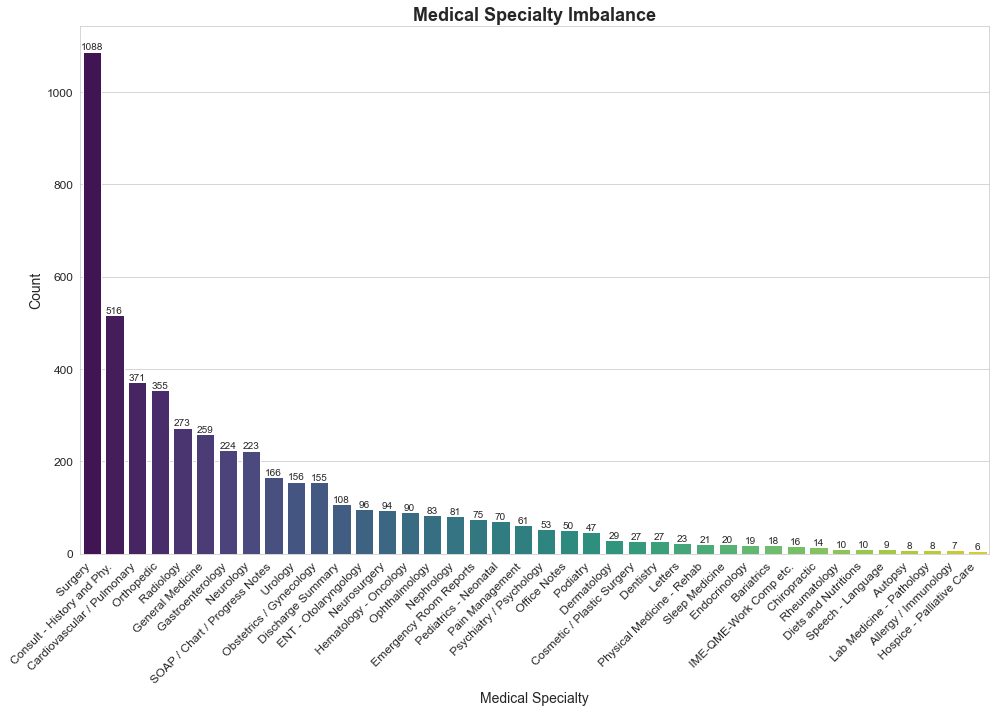

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

specialty_counts = df['medical_specialty'].value_counts()
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))
sns.barplot(x=specialty_counts.index, y=specialty_counts.values, palette="viridis")
plt.title('Medical Specialty Imbalance', fontsize=18, fontweight='bold')
plt.xlabel('Medical Specialty', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
for index, value in enumerate(specialty_counts.values):
    plt.text(index, value, f'{value}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()


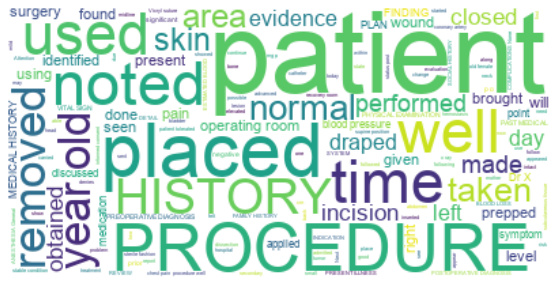

In [5]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# Assuming df is your DataFrame and 'description' is the column with text data
text = " ".join(description for description in df['transcription'])

# font_path = '/System/Library/Fonts/Helvetica.ttf'
font_path = '/System/Library/Fonts/Arial.ttf'

# Create and generate a word cloud image
wordcloud = WordCloud(background_color='white', font_path=font_path).generate(text)

# Display the generated WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [7]:
df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


Average AUC ROC: 0.772919788579183


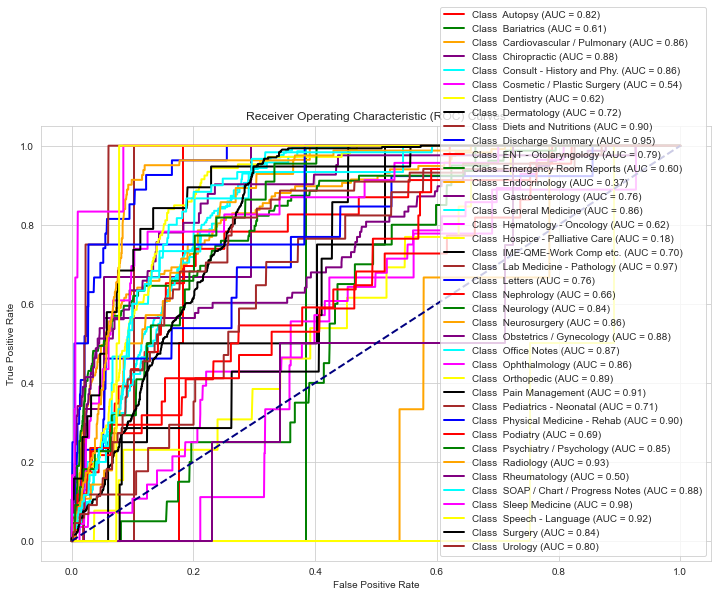

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
import numpy as np

X = df['transcription']
y = df['medical_specialty']

# Vectorizing the text data
td = TfidfVectorizer(max_features=4500)
X = td.fit_transform(X).toarray()

# Encoding the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
classes = le.classes_

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=0)

# Training the classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predicting probabilities for each class
y_score = classifier.predict_proba(X_test)

# Calculating ROC AUC for each class and averaging
roc_auc_scores = []
for i in range(len(classes)):
    actual = (y_test == i).astype(int)
    predicted = y_score[:, i]
    
    # Check if the true label contains at least one positive and one negative sample
    if len(np.unique(actual)) > 1:
        roc_auc = roc_auc_score(actual, predicted)
        roc_auc_scores.append(roc_auc)

roc_auc_avg = np.mean(roc_auc_scores)
print('Average AUC ROC:', roc_auc_avg)

# Colors for different ROC curves
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'brown']

plt.figure(figsize=(12, 8))

# Plot ROC curve for each class
for i in range(len(classes)):
    # Check if the true label contains at least one positive and one negative sample
    if len(np.unique(y_test == i)) > 1:
        fpr, tpr, _ = roc_curve(y_test == i, y_score[:, i])
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2, 
                 label=f'Class {classes[i]} (AUC = {auc(fpr, tpr):0.2f})')

# Plot diagonal line (represents a no-skill classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

###### Try also with Logistic Regression and OvA as this is an imbalanced class dataset

Average AUC ROC: 0.9460817293263801


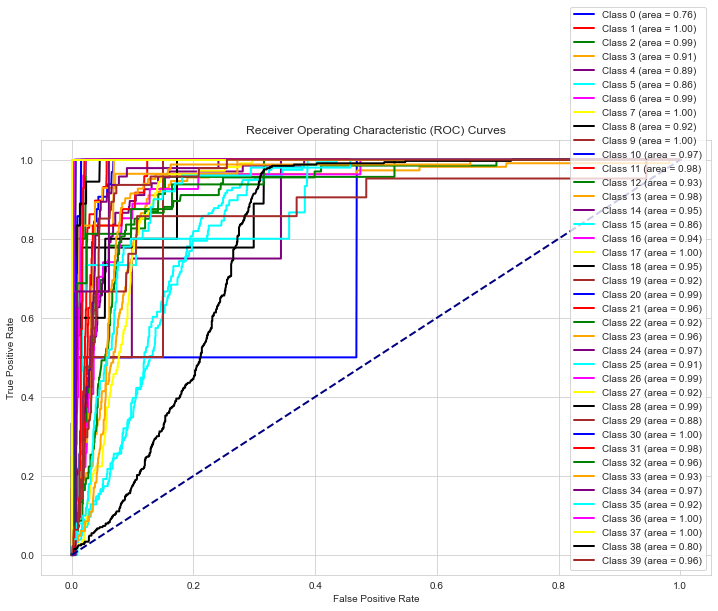

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

# Assuming 'dataset' is your DataFrame with two columns: transcription and medical_speciality
X = df['transcription']  # Transcriptions
y = df['medical_specialty'] # Medical Specialities

# Binarize the output labels for multi-class
y_binarized = label_binarize(y, classes=np.unique(y))
n_classes = y_binarized.shape[1]

# Building a TF-IDF matrix out of the corpus of transcriptions
td = TfidfVectorizer(max_features=4500)
X = td.fit_transform(X).toarray()

# Splitting into training & test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_binarized, test_size=0.3, 
                                                    random_state=0, stratify=y)
# Create a One-vs-Rest Logistic Regression classifier
classifier = OneVsRestClassifier(LogisticRegression(class_weight='balanced'))
classifier.fit(X_train, y_train)

# Predict probabilities for each class
y_score = classifier.predict_proba(X_test)

# Compute ROC AUC for each class and average
roc_auc = []
for i in range(n_classes):
    # Check if the true label contains at least one positive and one negative sample
    if len(np.unique(y_test[:, i])) > 1:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc.append(auc(fpr, tpr))

# Safe averaging, ignoring 'nan' values
roc_auc_avg = np.nanmean(roc_auc)

print('Average AUC ROC:', roc_auc_avg)


# Colors for different ROC curves
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'brown']

plt.figure(figsize=(12, 8))

# Plot ROC curve for each class
for i in range(n_classes):
    if len(np.unique(y_test[:, i])) > 1:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2, label=f'Class {i} (area = {auc(fpr, tpr):0.2f})')

# Plot diagonal line (represents a no-skill classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()